___
**Code cells for visuals**

In [63]:
import pandas as pd
import duckdb as dd
import numpy as np
import seaborn as sns
import numpy as np
import plotly.express as px
import ipywidgets as w
from ipywidgets.embed import embed_minimal_html 
from ipywidgets import SelectMultiple, VBox, Output
from IPython.display import display
import plotly.express as px
import warnings 
warnings.simplefilter("ignore")
def gini_coefficient(x):
    if len(x) == 0:
        return np.nan
    x = np.sort(np.array(x))
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

In [3]:
# Create an in-memory DuckDB connection
conn = dd.connect(':memory:')

In [4]:
query = """
SELECT
       *,                                                -- every column in the CSV
       CAST(
            regexp_extract(filename,
                           '/sept-yearling/([0-9]{4})/', -- capture the 4‑digit dir
                           1)                             -- first capture group
            AS INTEGER)           AS sale_year
FROM read_csv_auto(
       '../data/keeneland/sept-yearling/*/lots.csv',
       FILENAME = TRUE        -- adds a “filename” column with the full path
);
"""

buyers_query = """
SELECT 
    *
FROM buyers.csv
"""

sellers_query = """
SELECT 
    *
FROM sellers.csv
"""

df = conn.sql(query).df()
buyers = conn.sql(buyers_query).df()
sellers = conn.sql(sellers_query).df()

In [23]:
df

,Session,Hip,PropertyLine1,PropertyLine2,Description,DOB,Color,Sex,Horse Name,Sire,Dam,CoveringSire,LastService,Pregnancy,SoldAs,Purchaser,Price,filename,sale_year
0,1,0001,"Lane's End, Agent",None,Concord Bridge,None,B,Colt,Concord Bridge,Medaglia d'Oro,Pauline Revere,None,None,None,None,Talla Racing & West Point Thoroughbreds,850000,../data/keeneland/sept-yearling/2022/lots.csv,2022
1,1,0002,Summerfield (Francis and Barbara Vanlangendonc...,None,Uncoachable,None,B,Colt,Uncoachable,Into Mischief,Peggy Jane,None,None,None,None,Out,0,../data/keeneland/sept-yearling/2022/lots.csv,2022
2,1,0003,"Gainesway, Agent X",None,Reserve Fund,None,CH,Filly,Reserve Fund,Tapit,Pension,None,None,None,None,"Steven W. Young, Agent",650000,../data/keeneland/sept-yearling/2022/lots.csv,2022
3,1,0004,Dixiana Farms LLC,None,Paparazzo,None,B,Colt,Paparazzo,American Pharoah,Photographer,None,None,None,None,"Quarter Pole Enterprises, LLC",200000,../data/keeneland/sept-yearling/2022/lots.csv,2022
4,1,0005,"Taylor Made Sales Agency, Agent LXI",None,Blood Brother,None,B,Colt,Blood Brother,Quality Road,Pine Needles,None,None,None,None,Calumet Farm,100000,../data/keeneland/sept-yearling/2022/lots.csv,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30244,13,4534,"Stuart Morris, Agent I",None,Battlebot,None,CH,Filly,Battlebot,Sky Mesa,Grace That Abounds,None,None,None,None,Whitman Sales,1000,../data/keeneland/sept-yearling/2018/lots.csv,2018
30245,13,4535,"Meadowlark Valley Sales Agency, Agent",None,Baby Brother,None,B,Colt,Baby Brother,Conveyance,Grandpa's Legacy,None,None,None,None,Robert Campbell,2000,../data/keeneland/sept-yearling/2018/lots.csv,2018
30246,13,4536,"Vinery Sales, Agent LX",None,Lucille of Troy,None,DB/BR,Filly,Lucille of Troy,Revolutionary,Greeley Appealing,None,None,None,None,"R.N.A. (3,000)",---,../data/keeneland/sept-yearling/2018/lots.csv,2018
30247,13,4537,"Shawhan Place LLC, Agent for Mec Com at Hedber...",None,Nocentsinkentucky,None,CH,Colt,Nocentsinkentucky,Goldencents,Greeley's Geisha,None,None,None,None,Out,0,../data/keeneland/sept-yearling/2018/lots.csv,2018


In [37]:
only_sold = df.loc[(df.Price!="0") & (df.Price!="---")]
only_sold["Price"] = only_sold["Price"].astype(int)
sire_data = only_sold.groupby('Sire').agg(foal_count=('Hip', 'count'),
                                          total_sales=('Price', 'sum'),
                                          median_price=('Price', 'median'),
                                          variance_sales=('Price', 'std'),
                                          gini_coef=('Price', gini_coefficient),
                                          years_active=('sale_year', pd.Series.nunique))

/var/folders/1n/_5cwbc2d69ngrp58c7b7mk1h0000gq/T/ipykernel_41286/1287857008.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
sire_data['avg_price'] = sire_data.total_sales / sire_data.foal_count
sire_data['foals_per_year'] = sire_data.foal_count / sire_data.years_active
sire_data["gini_lag"] = (
    sire_data
    .groupby("Sire")               
    ["gini_coef"]                  
    .shift(1)                     
)

In [39]:
sire_data.to_csv('sire_data.csv')

___

## Overview
I included 3 interactive visuals below based on Keeneland Sept Yearling sales data from 2018-2024. The first visual allows you to look at Sire performances by year - the other two have more detailed explanations. I'll do more work on individual purchasers and sellers at auctions next while also cleaning and integrating OBS breeze data. 

I'd like to build a model that can estimate the price of a 2yo in the OBS sale based on their breeze time along with yearling sales prices, family performance, etc. The OBS results could then be fed back into another model predicting yearling sales, which creates a constantly improving feedback loop that adjusts in real-time. 

[Racing Squared](https://racingsquared.com/) is an example of what's possible: they use pose estimation and computer vision to assess a horse's conformation automatically in addition to all data points I mentioned above. This is an area I've worked in before and fortunately Keeneland/OBS/etc all post walking videos of their horses, so building a similar conformation-based AI tool is do-able given time. But for now...a few visuals.

___

### Sire Sales Performance by Year
- Search for a sire and select
- Clear selections with CTRL+"click" or CMD+"click" on each sires name or by deleting the typed entry

This is a little cumbersome to use, but was easiest to make quickly. You can exclude sales prices in the 95th percentile or higher using the "Excluding..." option in the Data filter. I would select "Excluding..." when looking at all data unless you specifically want to see some of the high priced outliers, otherwise the visual is compressed and uninterpretable.

The "Full" option will be more useful when looking at individual sires. 

**Notes:**
- When you highlight each box within each year you'll see a bunch of values.
    - upper_fence/lower_fence: These basically mark the start of where true outliers begin. They fluctuate based on the data but it's safe to assume they sit somewhere around the 10th and 90th percentiles.
    - q3: 75th percentile
    - median: 50th percentile
    - q1: 25th percentile

In [30]:
import plotly.express as px
import ipywidgets as w
from IPython.display import display
import pandas as pd

# ── build the two DataFrames up front ──────────────────────────
full_df     = only_sold.copy()
subset_df   = full_df[full_df.Price <= full_df.Price.quantile(.95)]

# a master list of sires (covers both data sets)
all_sires   = sorted(full_df["Sire"].unique())

# ── widgets ────────────────────────────────────────────────────
data_toggle = w.ToggleButtons(
    options=["Excluding >95th Percentile", "Full"],
    description="Data:"
)

sire_search      = w.Text(placeholder="Search sire…", layout=w.Layout(width="50%"))
sire_multiselect = w.SelectMultiple(options=all_sires, rows=8, layout=w.Layout(width="50%"))

fig_out = w.Output()

# --------------------------------------------------------------
def _filter_options(text_widget, multi_widget, full_list):
    """Live-filter the options in a SelectMultiple, keep existing selections."""
    pat  = text_widget.value.strip().lower()
    keep = multi_widget.value
    opts = [o for o in full_list if pat in o.lower()]
    multi_widget.options = opts
    # restore any choices that are still present after filtering
    multi_widget.value   = tuple(o for o in keep if o in opts)

sire_search.observe(
    lambda ch: _filter_options(sire_search, sire_multiselect, all_sires),
    names="value"
)

# --------------------------------------------------------------
def redraw(_=None):
    # 1️⃣ choose which DataFrame to plot
    df = subset_df if data_toggle.value.startswith("Excluding") else full_df

    # 2️⃣ apply the sire filter (if any)
    if sire_multiselect.value:
        df = df[df["Sire"].isin(sire_multiselect.value)]

    # 3️⃣ draw / update the figure
    with fig_out:
        fig_out.clear_output(wait=True)
        px.box(
            df, x="sale_year", y="Price",
            hover_data=["Sire", "Description", "Purchaser"],
            title="Keeneland Sept Yearling Sales by Sire"
        ).show()

# trigger redraw whenever a control changes
for widg in (data_toggle, sire_multiselect):
    widg.observe(redraw, names="value")

# initial plot
redraw()

# ── layout ────────────────────────────────────────────────────
display(
    w.VBox([
        data_toggle,
        w.HTML("<b>Sire filter</b>"),
        sire_search,
        sire_multiselect,
        fig_out
    ])
)



___

**Sire Sales Performance vs Gini**

"Gini" is traditionally used in research for things like income inequality because it captures how similar or different members of a population are from one another. A gini of 0.0 indicates the highest degree of similarity meaning all outcomes (or in this case yearling sales prices) are identical - if a sire's progeny sold in the range of 5k to 5M the sire would receive close to a 1.0 gini (extreme volatility). Conversely, a gini of 0.0 indicates zero variation for a sire's yearling prices. 

If a sire has a relatively high gini and a relatively low median price, that could indicate that the sire is more risky since the potential sales price is more volatile and is lower in general (see: Improbable). The opposite is true for Into Mischief whose low gini is matched by the highest median price. There's obvious bias here because high performing sires have their choice of optimal mares, but directionally I think the trend holds. If you want to see how younger sires are performing, then change the "Years active" slider.

**Notes:**
- I did not include "Out" and "RNA" values here which means this is skewed data. Directionally it's probably correct, but it may be the case that Blame (0.497 gini) RNAs 2x as much as Volatile (0.562 gini) potentially making Blame a less desireable option all things considered. 
- Gini is less reliable for Sires with low foal counts hence the large spread for sires under 50k - I would use a Foal count of 10 or more.
- Many of these sires have been active for more than 7 years, but I only have data back to 2017 so this is all I can work with.

In [59]:
import plotly.express as px
import ipywidgets as w
from IPython.display import display

def plot_dynamic(circle_size="foals_per_year"):
    """
    Interactive scatter with:
      • x-axis  : gini_coef
      • y-axis  : avg_price
      • size / colour : <circle_size> column
      • filters :
            foals_per_year ≥ F
            years_active between [Ymin, Ymax]
    """
    # ── widgets ────────────────────────────────────────────────
    foal_min = w.IntText(value=1, description="Foals per year ≥", step=1)

    yr_min, yr_max = int(sire_data.years_active.min()), int(sire_data.years_active.max())
    year_range = w.IntRangeSlider(
        value=[yr_min, yr_max], min=yr_min, max=yr_max, step=1,
        description="Years active",
        continuous_update=False, layout=w.Layout(width="75%")
    )

    fig_out = w.Output()

    # ── redraw helper ─────────────────────────────────────────
    def redraw(*_):
        lo, hi = year_range.value
        df = sire_data.loc[
            (sire_data.foals_per_year >= foal_min.value) &
            (sire_data.years_active.between(lo, hi))
        ]
        with fig_out:
            fig_out.clear_output(wait=True)
            px.scatter(
                df.reset_index(),
                x="gini_coef", y="median_price",
                size=circle_size, color=circle_size,
                hover_name="Sire",
                color_continuous_scale="plasma",
                title="Sire scatter (interactive thresholds)"
            ).show()

    # update on any control change
    foal_min.observe(redraw, names="value")
    year_range.observe(redraw, names="value")

    redraw()  # initial draw

    # ── lay out the controls and figure ───────────────────────
    display(w.VBox([
        w.HBox([foal_min, year_range]),
        fig_out
    ]))

# call the function to launch the UI
plot_dynamic("foals_per_year")        # or another column name






___

### Gini vs Median Price Correlation

This visual tells is meant to tell us how the relationship between gini (sales price volatility) and median price evolve over time. A positive correlation tells us that when gini goes up (i.e. volatility increases) then median price also goes up, so the two move in the same direction. Normally I would expect this relationship to be negative because more volatility would equate to a less desireable sire, and a less desireable sire would lead to lower sales prices.

What's interesting is that the correlation is positive for sires in their second year. So a 2nd year crop tends to see **higher volatility present at the same time as higher prices** - i.e. buyers are taking big-time shots on horses and presumably gambling on a sire's first crop performing well as 2yo's. I would assume a sire's second crop is a highly active (and potentially highly profitable) time for good pinhookers hoping to flip at the spring breeze sales, but I would need data to back that up. 

**Notes:**
1. Filter by foals >= 10 at minimum, otherwise the small sample sires distort the picture.
2. Changing years active won't change the underlying correlations - I probably could have deleted it. 
3. Correlation statistics are inherently volatile themselves, so like the two outputs above I wouldn't interpret these too literally (yet).

In [66]:
import pandas as pd, plotly.express as px, ipywidgets as w
from IPython.display import display

# --------------------------------------------------------------------------
# EXPECTS a DataFrame called `sire_data` with at least these columns:
#   'Sire', 'foals_per_year', 'years_active', 'gini_coef', 'avg_price'
# --------------------------------------------------------------------------

df0 = sire_data.reset_index().copy()

# ── master lists / limits ─────────────────────────────────────────────────
yr_min, yr_max = int(df0.years_active.min()), int(df0.years_active.max())

# ── widgets ───────────────────────────────────────────────────────────────
foal_min = w.IntText(value=1, description="Foal ≥", step=1,
                     layout=w.Layout(width="150px"))

year_range = w.IntRangeSlider(
    value=[yr_min, yr_max], min=yr_min, max=yr_max, step=1,
    description="Years active", continuous_update=False,
    layout=w.Layout(width="70%")
)

plot_out = w.Output()

# ── helper: live-filter the SelectMultiple options list ───────────────────
def _filter_options(text_widget, multi_widget, full_list):
    pat = text_widget.value.strip().lower()
    keep = multi_widget.value
    opts = [o for o in full_list if pat in o.lower()]
    multi_widget.options = opts
    multi_widget.value = tuple(o for o in keep if o in opts)

sire_search.observe(
    lambda c: _filter_options(sire_search, sire_multiselect, all_sires),
    names="value"
)

# ── recompute + redraw ────────────────────────────────────────────────────
def redraw(_=None):
    lo, hi = year_range.value

    # 1️⃣ apply filters
    d = df0.loc[
        (df0.foals_per_year >= foal_min.value) &
        (df0.years_active.between(lo, hi))
    ]

    # 2️⃣ group by years_active and compute Pearson r
    corr_by_year = (
        d.groupby("years_active")
         .apply(lambda g: g["gini_coef"].corr(g["median_price"]))
         .dropna()
         .reset_index(name="corr")
         .sort_values("years_active")
    )

    # 3️⃣ draw the line plot
    with plot_out:
        plot_out.clear_output(wait=True)
        if corr_by_year.empty:
            print("No data after filters.")
            return
        fig = px.line(
            corr_by_year, x="years_active", y="corr",
            markers=True,
            title="Correlation (gini coef ↔ median price) by years active"
        )
        fig.update_layout(
            yaxis_title="Correlation [-1,1]", xaxis_title="Years active",
            yaxis=dict(range=[-1, 1])
        )
        fig.show()

# watch every control
for widg in (foal_min, year_range, sire_multiselect):
    widg.observe(redraw, names="value")

# initial draw
redraw()

ui = w.VBox([
        w.HBox([foal_min, year_range]),
        plot_out
     ])

display(ui)                 # still shows in the notebook

# ── export that *same* widget tree to a standalone HTML file --------------
embed_minimal_html(
    "correlation_view.html",   # output filename
    views=[ui],                # list of top-level widgets to capture
    title="Lag-1 Gini vs Median Price",
    requirejs=False  # leave default; set False if the page must work offline
)

print("✔  Saved interactive view to correlation_view.html")


✔  Saved interactive view to correlation_view.html


___

**Extra code for later**

In [17]:
corr = sire_data.loc[(sire_data.foals_per_year>=10) & (sire_data.years_active>=5)].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,foal_count,total_sales,variance_sales,gini_coef,years_active,avg_price,foals_per_year
foal_count,1.00,0.79,0.59,-0.55,0.44,0.61,0.97
total_sales,0.79,1.00,0.85,-0.65,0.31,0.91,0.77
variance_sales,0.59,0.85,1.00,-0.54,0.29,0.94,0.57
gini_coef,-0.55,-0.65,-0.54,1.00,-0.21,-0.68,-0.55
years_active,0.44,0.31,0.29,-0.21,1.00,0.28,0.23
avg_price,0.61,0.91,0.94,-0.68,0.28,1.00,0.60
foals_per_year,0.97,0.77,0.57,-0.55,0.23,0.60,1.00


In [18]:
correlation_by_group = {}

for yr in sire_data.years_active.unique():
    corr = sire_data.loc[sire_data.years_active==yr][['gini_coef', 'avg_price', 'foal_count', 'variance_sales']].corr()
    correlation_by_group[yr] = corr


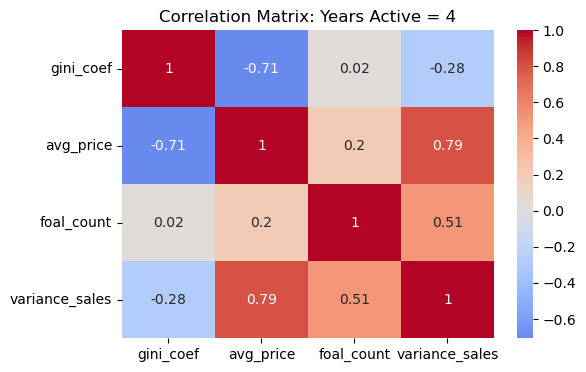

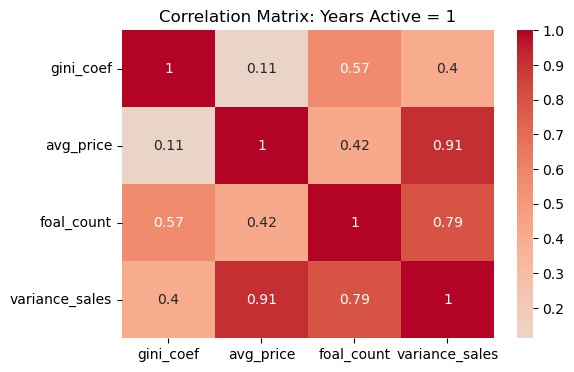

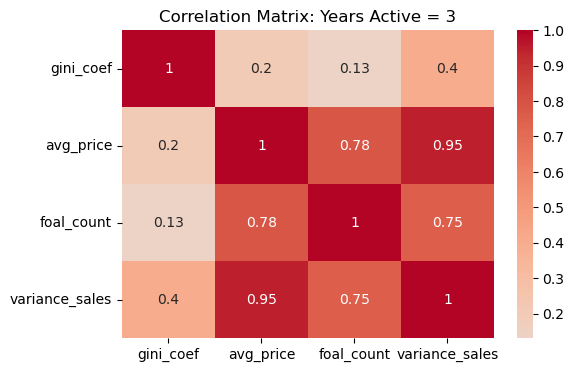

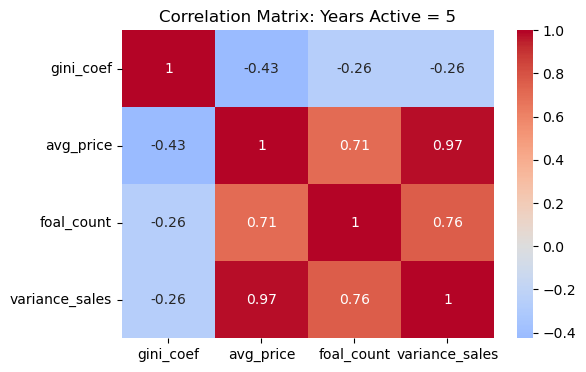

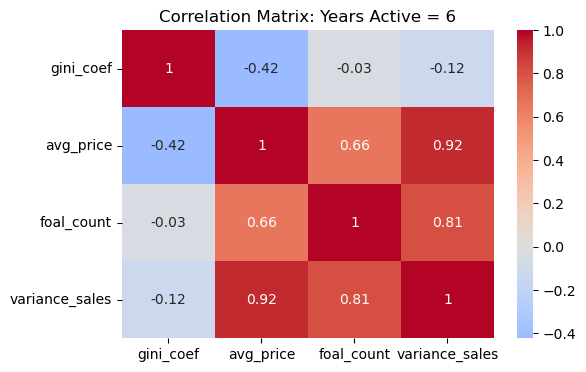

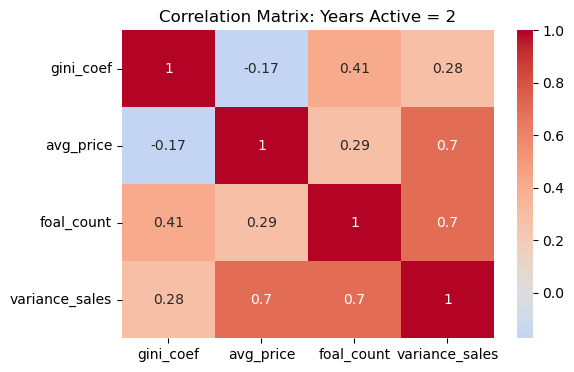

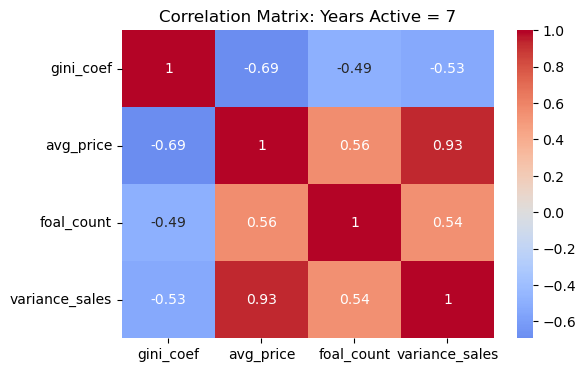

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

for group, corr in correlation_by_group.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title(f'Correlation Matrix: Years Active = {group}')
    plt.show()


In [20]:
yearly_ginis = (
    only_sold.loc[only_sold.Sire.isin(list(sire_data.loc[sire_data.years_active<=4].index.unique()))]
    .groupby(['Sire', 'sale_year'])
    .agg(gini=('Price', gini_coefficient))
    .reset_index()
)


In [21]:
first_crop = only_sold.groupby('Sire')['sale_year'].min().rename('first_year')
yearly_ginis = yearly_ginis.merge(first_crop, on='Sire')
yearly_ginis['years_since_first_crop'] = yearly_ginis['sale_year'] - yearly_ginis['first_year']


In [22]:
yearly_ginis

,Sire,sale_year,gini,first_year,years_since_first_crop
0,Accelerate,2021,0.455209,2021,0
1,Accelerate,2022,0.344875,2021,1
2,Accelerate,2023,0.324065,2021,2
3,Accelerate,2024,0.000000,2021,3
4,Acclamation,2019,0.000000,2019,0
...,...,...,...,...,...
688,Yoshida (JPN),2022,0.406283,2022,0
689,Yoshida (JPN),2023,0.381746,2022,1
690,Yoshida (JPN),2024,0.386986,2022,2
691,Zoffany (IRE),2018,0.125000,2018,0


In [23]:
df['breeding_year'] = df['sale_year'] - 2

In [24]:
sire_base = df[['Sire', 'breeding_year']].drop_duplicates().reset_index(drop=True)

In [25]:
sire_base.to_csv('stud_fee_incomplete.csv')

In [26]:
sire_base

,Sire,breeding_year
0,Medaglia d'Oro,2020
1,Into Mischief,2020
2,Tapit,2020
3,American Pharoah,2020
4,Quality Road,2020
...,...,...
1443,Bellamy Road,2016
1444,Skipshot,2016
1445,Ready's Image,2016
1446,Grasshopper,2016


In [28]:
sire_unique = df[['Sire', 'sale_year']].drop_duplicates().reset_index(drop=True)

In [30]:
sire_unique.groupby('Sire').agg(sale_year=('sale_year', 'min')).reset_index().to_excel('sires.xlsx', index=False)

/var/folders/1n/_5cwbc2d69ngrp58c7b7mk1h0000gq/T/ipykernel_94737/1928292227.py:1: UserWarning:

Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).



In [1]:
!python bloodhorse_stud_fee_scraper.py --input sires.csv --output stud_fees.csv

^C
Traceback (most recent call last):
  File "/Users/bpoe/Documents/personal/ring0-auction-valuation/notebooks/bloodhorse_stud_fee_scraper.py", line 28, in <module>
    import pandas as pd
  File "/Users/bpoe/opt/anaconda3/lib/python3.9/site-packages/pandas/__init__.py", line 49, in <module>
    from pandas.core.api import (
  File "/Users/bpoe/opt/anaconda3/lib/python3.9/site-packages/pandas/core/api.py", line 47, in <module>
    from pandas.core.groupby import (
  File "/Users/bpoe/opt/anaconda3/lib/python3.9/site-packages/pandas/core/groupby/__init__.py", line 1, in <module>
    from pandas.core.groupby.generic import (
  File "/Users/bpoe/opt/anaconda3/lib/python3.9/site-packages/pandas/core/groupby/generic.py", line 68, in <module>
    from pandas.core.frame import DataFrame
  File "/Users/bpoe/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py", line 149, in <module>
    from pandas.core.generic import (
  File "/Users/bpoe/opt/anaconda3/lib/python3.9/site-packages/pa

In [ ]:
import re
import textwrap
from pathlib import Path

import requests
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.chrome.options import Options

opts = Options()
opts.add_argument("--headless=new")   # Chrome >115 headless mode
driver = webdriver.Chrome(options=opts)
url = "https://www.bloodhorse.com/stallion-register/stallions/170525/accelerate/auctions/2021"

driver.get(url)               # Incapsula challenge loads & runs
html = driver.page_source      # now holds the real auctions page
# ...


# URL = "https://www.bloodhorse.com/stallion-register/stallions/170525/accelerate/auctions/2021"

# resp = requests.get(
#     URL,
#     headers={
#         "User-Agent": (
#             "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
#             "AppleWebKit/537.36 (KHTML, like Gecko) "
#             "Chrome/124.0.0.0 Safari/537.36"
#         )
#     },
#     timeout=20,
# )
# resp.raise_for_status()      # will raise if status ≠ 200
# html = resp.text

In [2]:
# ⬇️  run this cell in Jupyter

# ------------------------------------------------------------------
# 1. one‑time installs (comment out after first run)
# %pip install -q selenium webdriver-manager beautifulsoup4 lxml

# ------------------------------------------------------------------
import re
# ⬇️  run / replace in your notebook cell
from selenium import webdriver
from selenium.webdriver.chrome.service import Service            # NEW import
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

URL = "https://www.bloodhorse.com/stallion-register/stallions/170525/accelerate/auctions/2021"



chrome_opts = Options()
# chrome_opts.add_argument("--headless=new")      # Chrome ≥115
chrome_opts.add_argument("--disable-gpu")
chrome_opts.add_argument("--no-sandbox")
chrome_opts.add_argument("--window-size=1920,1080")

service = Service(ChromeDriverManager().install())               # wrap path
driver = webdriver.Chrome(service=service, options=chrome_opts)  # pass BOTH

try:
    # 3. navigate and let the page finish loading
    driver.get(URL)
    driver.implicitly_wait(5)   # seconds; tweak if your net is slow

    # 4. page_source now contains the real HTML
    html = driver.page_source
finally:
    driver.quit()

# ------------------------------------------------------------------
# 5. parse the Weanlings section for '<YEAR> Stud Fee $<amount>'
soup = BeautifulSoup(html, "lxml")
header = soup.find(string=re.compile(r"\bWeanlings\b", re.I))

def stud_fee_from_weanlings(html: str) -> dict[int, int]:
    """
    Return {stud_fee_year: stud_fee_usd} for the Weanlings tab only.
    """
    soup = BeautifulSoup(html, "lxml")

    # find the first Weanlings <ul class="tabs"><li> or the header string
    weanlings_li = soup.find("li", string=re.compile(r"\bWeanlings\b", re.I))
    if not weanlings_li:
        return {}

    # the <ul class="tabs"> is the parent; the corresponding tabPane is next
    tab_ul = weanlings_li.find_parent("ul", class_="tabs")
    tab_pane = tab_ul.find_next_sibling("div", class_="contentBlock")
    if not tab_pane:
        return {}

    # within that pane, the <li> that starts with 'YYYY Stud Fee'
    fee_li = tab_pane.find("li", string=re.compile(r"^\d{4}\s+Stud\s+Fee", re.I))
    if not fee_li:
        return {}

    m = re.match(r"(?P<yr>\d{4})\s+Stud\s+Fee:\s+\$(?P<amt>[\d,]+)", fee_li.text)
    if not m:
        return {}

    yr = int(m.group("yr"))
    amt = int(m.group("amt").replace(",", ""))
    return {yr: amt}

fee_dict = stud_fee_from_weanlings(html)
print(fee_dict)  

# fees = {}
# if header:
#     sec = header.find_parent()
#     table = next((sib for sib in sec.find_all_next() if sib.name == "table"), None)
#     if table:
#         fee_re = re.compile(r"(\d{4})\s*Stud\s*Fee", re.I)
#         for tr in table.find_all("tr"):
#             tds = tr.find_all("td")
#             if len(tds) < 2:
#                 continue
#             m = fee_re.match(tds[0].get_text(strip=True))
#             if not m:
#                 continue
#             yr = int(m.group(1))
#             amt_txt = (
#                 tds[1].get_text(strip=True).replace("$", "").replace(",", "")
#             )
#             fees[yr] = int(amt_txt) if amt_txt.isdigit() else None

# fees


{2020: 20000}


In [4]:
header = soup.find(string=re.compile(r"\bWeanlings\b", re.I))

In [10]:
header

'Weanlings'

In [11]:
soup

<html class="notranslate" lang="en-us" translate="no" xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/"><head><script async="" crossorigin="anonymous" src="https://connect.facebook.net/en_US/sdk.js?hash=f8eb86b51960670e07a8818c5e9ae4ce"></script><script id="facebook-jssdk" src="https://connect.facebook.net/en_US/sdk.js#xfbml=1&amp;version=v3.1&amp;appId=131856666853481&amp;autoLogAppEvents=1"></script><script async="" src="/luble-set-gaze-Starrelate-Macb-Sonne-Like-made-W"></script>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<meta content="en-us" http-equiv="content-language"/>
<meta content="notranslate" name="google"/>
<title>Accelerate | 2021 Worldwide Sales Results - Stallion Register Online</title>
<meta content="width=1024" name="viewport"/>
<link href="//cdn.bloodhorse.com/stallion-register/styles/default.css" m